# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

### Imports

In [1]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import abc

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

Using TensorFlow backend.


In [3]:
import cv2
import matplotlib.pyplot as plt
% matplotlib inline

In [4]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.applications import mobilenet

### Plot Helper

In [5]:
def plot(history):
    """
    1. Plots loss Vs val_loss
    2. Plots categorical_accuracy Vs val_categorical_accuracy
    """
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])
    
    axes[1].plot(history.history['categorical_accuracy'])
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy', 'val_categorical_accuracy'])

### Base Model

In [6]:
# uncomment the line below before submission
# project_folder = '/notebooks/storage/Final_data/Collated_training' 

# comment the line below before submission
project_folder = './Project_data'

# Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with img_idx, y,z and normalization such that you get high accuracy.

In [7]:
class ModelBuilder(abc.ABC):
    
    def __init__(self, project_folder, num_epochs=30, batch_size=30, image_height=84, image_width=84, 
                 frames_to_sample=30):
        """
        constructor to initialize path, batch_size, num_epochs, image_height, image_width, frames to sample
        
        """
        # training and validation data info
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path = project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
        # hyperparams
        self.frames_to_sample = frames_to_sample # max 30
        self.num_epochs = num_epochs             # np. of epochs
        self.batch_size = batch_size             # batch size 
        
        # fixed properties
        self.channels = 3                       # 3 channels - R,G,B
        self.num_classes = 5                     # no of classes - 5 
        self.no_of_frames = 30
        
        # image properties
        self.image_height = image_height
        self.image_width = image_width
        
        
        
    def load_batch_data(self, source_path, folder_list, batch_num, batch_size, t, augment=False):
        """
        loads the batch data from source_path/folder_list of batch_size
        it also augments the data if true
        """
        img_idx = np.round(np.linspace(0, self.no_of_frames-1, self.frames_to_sample)).astype(int)

        batch_data = np.zeros((batch_size, len(img_idx), self.image_height, self.image_width, self.channels))
        batch_labels = np.zeros((batch_size, 5)) # batch_labels is the one hot representation of the output
        if augment:
            batch_data_aug = np.zeros((batch_size, len(img_idx), self.image_height, self.image_width, self.channels))
            
        for folder in range(batch_size): # iterate over the batch_size
            # read all the images in the folder
            imgs = imgs = os.listdir(source_path+'/'+ t[folder + (batch_num*batch_size)].split(';')[0])
            
            for idx, item in enumerate(img_idx):
                image = imread(source_path+'/'+ t[folder + (batch_num*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                
                # crop the images & resize them. Note that the images are of 2 different shape
                # and the conv3D will throw error if the inputs in a batch have different shapes
                image_resized = imresize(image, (self.image_height, self.image_width, 3))
                
                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
                if augment:
                    shifted = cv2.warpAffine(image, np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), (image.shape[1], image.shape[0]))
                    gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0)
                    cropped = shifted[x0:x1,y0:y1,:]
                    image_resized = imresize(cropped,(self.image_height,self.image_width,3))
                    
                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2), np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))
                    
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                    
            batch_labels[folder, int(t[folder + (batch_num*batch_size)].strip().split(';')[2])] = 1
        
        if augment:
            batch_data = np.append(batch_data, batch_data_aug, axis=0)
            batch_labels = np.append(batch_labels, batch_labels, axis=0)
            
        return batch_data, batch_labels
    
    
    def generator(self, source_path, folder_list, augment=False):
        """
        generator function - generates & returns batch data after preprocessing
        """
        print( 'Source path = ', source_path, '; batch size =', self.batch_size)
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(folder_list) // self.batch_size # calculate the number of batches
            for batch in range(num_batches): # we iterate over the number of batches
                yield self.load_batch_data(source_path, folder_list, batch, self.batch_size, t, augment) 
            
            # write the code for the remaining data points which are left after full batches
            if (len(folder_list) != self.batch_size*num_batches):
                batch_size = len(folder_list) - (self.batch_size*num_batches)
                yield self.load_batch_data(source_path, folder_list, num_batches, batch_size, t, augment)
                
    
    def train_model(self, model, augment=False):
        """
        train models creates train & val generator
        creates models & train them
        """
        train_generator = self.generator(self.train_path, self.train_doc, augment)
        val_generator = self.generator(self.val_path, self.val_doc)
        
        curr_dt_time = datetime.datetime.now()
        model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)

        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, cooldown=1, verbose=1) # write the REducelronplateau code here
        callbacks_list = [checkpoint, LR]
        
        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history
    
    @abc.abstractmethod
    def define_model(self):
        pass

# Model 1 - Conv3D Model with less parameters

In [8]:
class Conv3DModel1(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(8, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(16, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [9]:
conv3d_model1 = Conv3DModel1(project_folder, image_height=120, image_width=120, frames_to_sample=16, 
                             batch_size=20, num_epochs=30)
conv3d_model1_Model = conv3d_model1.define_model(dense_neurons=64, dropout=0.25)
conv3d_model1_Model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 16, 120, 120, 8)   656       
_________________________________________________________________
activation_1 (Activation)    (None, 16, 120, 120, 8)   0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 120, 120, 8)   32        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 8, 60, 60, 8)      0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 8, 60, 60, 16)     3472      
_________________________________________________________________
activation_2 (Activation)    (None, 8, 60, 60, 16)     0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 60, 60, 16)     64        
__________

In [10]:
history_model1 = conv3d_model1.train_model(conv3d_model1_Model, augment=True)

Source path =  ./Project_data/val ; batch size = 20
Source path =  ./Project_data/train ; batch size = 20
Epoch 1/30
34/34 [==============================] - 187s 5s/step - loss: 2.0238 - categorical_accuracy: 0.2826 - val_loss: 1.4630 - val_categorical_accuracy: 0.4200

Epoch 00001: saving model to model_init_2020-03-2500_22_52.988425/model-00001-2.00655-0.28959-1.46298-0.42000.h5
Epoch 2/30
34/34 [==============================] - 107s 3s/step - loss: 1.4339 - categorical_accuracy: 0.4349 - val_loss: 1.1585 - val_categorical_accuracy: 0.5200

Epoch 00002: saving model to model_init_2020-03-2500_22_52.988425/model-00002-1.42934-0.43741-1.15852-0.52000.h5
Epoch 3/30
34/34 [==============================] - 90s 3s/step - loss: 1.3047 - categorical_accuracy: 0.4845 - val_loss: 1.0319 - val_categorical_accuracy: 0.6100

Epoch 00003: saving model to model_init_2020-03-2500_22_52.988425/model-00003-1.29283-0.48416-1.03187-0.61000.h5
Epoch 4/30
34/34 [==============================] - 89s 3s


Epoch 00029: saving model to model_init_2020-03-2500_22_52.988425/model-00029-0.51844-0.81146-0.72326-0.72000.h5
Epoch 30/30
34/34 [==============================] - 89s 3s/step - loss: 0.6024 - categorical_accuracy: 0.7822 - val_loss: 0.7240 - val_categorical_accuracy: 0.7200

Epoch 00030: saving model to model_init_2020-03-2500_22_52.988425/model-00030-0.54397-0.80166-0.72402-0.72000.h5


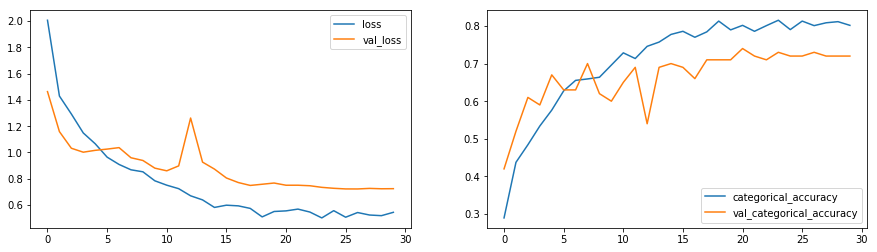

In [11]:
plot(history_model1)

This model is very lightweight model with only 2.3 lakhs trainable params and an accuracy of around 72%.
It can be used for mobile devices. 

# Model 2 - Conv3D Model with more parameters & accuracy

In [12]:
class Conv3DModel2(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [13]:
conv3d_model2 = Conv3DModel2(project_folder, image_height=160, image_width=160, frames_to_sample=20, 
                             batch_size=20, num_epochs=30)
conv3d_model2_Model = conv3d_model2.define_model(dense_neurons=256, dropout=0.5)
conv3d_model2_Model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_5 (Activation)    (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_6 (Activation)    (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 10, 80, 80, 32)    128       
__________

In [14]:
history_model2 = conv3d_model2.train_model(conv3d_model2_Model, augment=True)

Source path =  ./Project_data/val ; batch size = Source path =  ./Project_data/train ; batch size = 20
20
Epoch 1/30
34/34 [==============================] - 208s 6s/step - loss: 2.0212 - categorical_accuracy: 0.3598 - val_loss: 1.3571 - val_categorical_accuracy: 0.5100

Epoch 00001: saving model to model_init_2020-03-2501_10_41.056454/model-00001-2.03828-0.36048-1.35713-0.51000.h5
Epoch 2/30
34/34 [==============================] - 134s 4s/step - loss: 1.4817 - categorical_accuracy: 0.5155 - val_loss: 0.9550 - val_categorical_accuracy: 0.6600

Epoch 00002: saving model to model_init_2020-03-2501_10_41.056454/model-00002-1.47220-0.51584-0.95505-0.66000.h5
Epoch 3/30
34/34 [==============================] - 136s 4s/step - loss: 1.1652 - categorical_accuracy: 0.5912 - val_loss: 0.8598 - val_categorical_accuracy: 0.6700

Epoch 00003: saving model to model_init_2020-03-2501_10_41.056454/model-00003-1.18183-0.58522-0.85977-0.67000.h5
Epoch 4/30
34/34 [==============================] - 136s 

34/34 [==============================] - 136s 4s/step - loss: 0.3876 - categorical_accuracy: 0.8668 - val_loss: 0.5757 - val_categorical_accuracy: 0.7700

Epoch 00029: saving model to model_init_2020-03-2501_10_41.056454/model-00029-0.37544-0.87179-0.57573-0.77000.h5
Epoch 30/30
34/34 [==============================] - 135s 4s/step - loss: 0.4365 - categorical_accuracy: 0.8433 - val_loss: 0.5689 - val_categorical_accuracy: 0.7700

Epoch 00030: saving model to model_init_2020-03-2501_10_41.056454/model-00030-0.40436-0.85596-0.56893-0.77000.h5


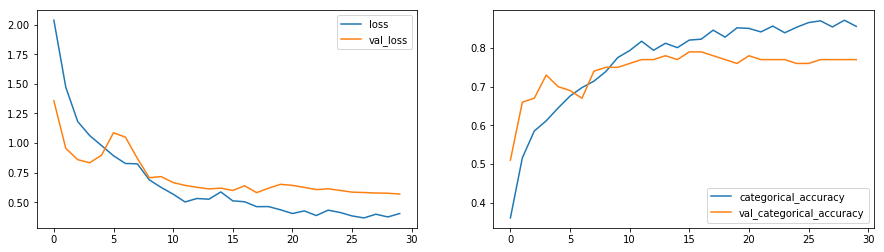

In [15]:
plot(history_model2)

This model has more accuracy than the last model but more no of trainable params (36 lakhs) and hence heavyweight.

# Model 3 - 2D CNN + RNN 

In [18]:
class Conv2DRNNModel(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        
        return model

In [19]:
rnn_cnn = Conv2DRNNModel(project_folder, image_height=120, image_width=120, frames_to_sample=18, batch_size=20,
                        num_epochs=20)
rnn_cnn_model = rnn_cnn.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_14 (TimeDis (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_15 (TimeDis (None, 18, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_16 (TimeDis (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_17 (TimeDis (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_18 (TimeDis (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_19 (TimeDis (None, 18, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_20 (TimeDis (None, 18, 30, 30, 64)    18496     
__________

In [20]:
history_model3 = rnn_cnn.train_model(rnn_cnn_model, augment=True)

Source path = Source path = Epoch 1/20 ./Project_data/train ; batch size = 20

 ./Project_data/val ; batch size = 20
34/34 [==============================] - 137s 4s/step - loss: 1.4974 - categorical_accuracy: 0.3554 - val_loss: 1.1193 - val_categorical_accuracy: 0.5800

Epoch 00001: saving model to model_init_2020-03-2502_21_22.729047/model-00001-1.50375-0.34766-1.11933-0.58000.h5
Epoch 2/20
34/34 [==============================] - 100s 3s/step - loss: 1.0451 - categorical_accuracy: 0.5684 - val_loss: 0.9870 - val_categorical_accuracy: 0.6400

Epoch 00002: saving model to model_init_2020-03-2502_21_22.729047/model-00002-1.04830-0.57014-0.98700-0.64000.h5
Epoch 3/20
34/34 [==============================] - 101s 3s/step - loss: 0.8278 - categorical_accuracy: 0.6939 - val_loss: 0.8651 - val_categorical_accuracy: 0.6900

Epoch 00003: saving model to model_init_2020-03-2502_21_22.729047/model-00003-0.83869-0.68627-0.86506-0.69000.h5
Epoch 4/20
34/34 [==============================] - 101s 

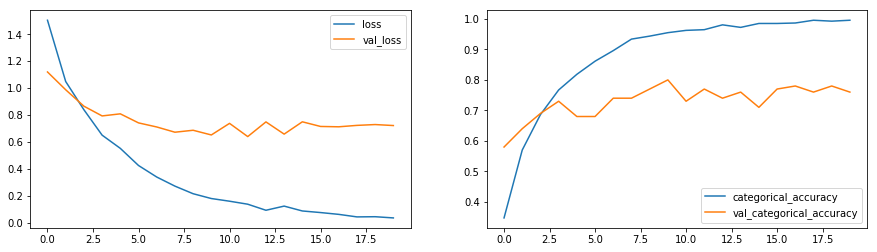

In [21]:
plot(history_model3)

This model is overfitting as the validation accuracy(0.76) is much less than the training accuracy(0.99).

# Model 4 - Transfer Learning (GRU & training all weights)

In [22]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class TL(ModelBuilder):
    
    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

17227776/17225924 [==============================] - 2s 0us/step


In [23]:
tl = TL(project_folder, image_height=120, image_width=120, frames_to_sample=16, batch_size=5, num_epochs=20)
tl_model = tl.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
tl_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_27 (TimeDis (None, 16, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_28 (TimeDis (None, 16, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_29 (TimeDis (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_30 (TimeDis (None, 16, 1024)          0         
_________________________________________________________________
gru_3 (GRU)                  (None, 128)               442752    
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               16512     
__________

In [24]:
history_model4 = tl.train_model(tl_model, augment=True)

Source path =  ./Project_data/val ; batch size = 5Source path =  ./Project_data/train ; batch size = 5
Epoch 1/20

133/133 [==============================] - 104s 784ms/step - loss: 1.1901 - categorical_accuracy: 0.5273 - val_loss: 0.8018 - val_categorical_accuracy: 0.6100

Epoch 00001: saving model to model_init_2020-03-2503_28_06.585956/model-00001-1.19208-0.52640-0.80176-0.61000.h5
Epoch 2/20
133/133 [==============================] - 93s 702ms/step - loss: 0.6937 - categorical_accuracy: 0.7446 - val_loss: 0.5438 - val_categorical_accuracy: 0.8200

Epoch 00002: saving model to model_init_2020-03-2503_28_06.585956/model-00002-0.69473-0.74434-0.54377-0.82000.h5
Epoch 3/20
133/133 [==============================] - 97s 732ms/step - loss: 0.4357 - categorical_accuracy: 0.8218 - val_loss: 0.3912 - val_categorical_accuracy: 0.8200

Epoch 00003: saving model to model_init_2020-03-2503_28_06.585956/model-00003-0.43662-0.82127-0.39118-0.82000.h5
Epoch 4/20
133/133 [==========================

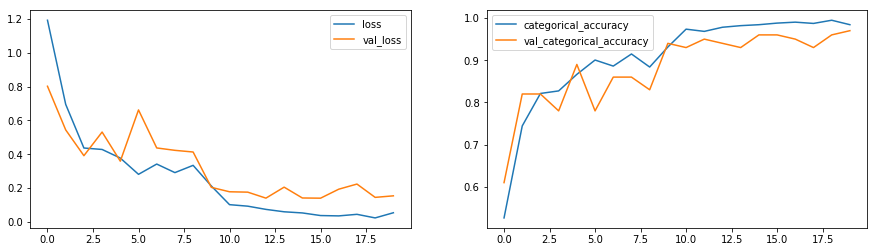

In [25]:
plot(history_model4)

This model has the best accuracy (0.97) so far and is also not overfitting but is heavy due to no of trainable params of about 36 lakhs. 